# Spatial manipulation of data

In addition to exposing xclim's indicators, Finch also provides spatial subsetting and averaging processes.

In [1]:
import os
import xarray as xr
from birdy import WPSClient

In [2]:
pavics_url = 'https://pavics.ouranos.ca/twitcher/ows/proxy/finch/wps'
url = os.environ.get('WPS_URL', pavics_url)
verify_ssl = True if 'DISABLE_VERIFY_SSL' not in os.environ else False
wps = WPSClient(url, verify=verify_ssl)

For the examples in this notebook, we are using a year of daily data, minimal temperature over southern Québec. Let's load it here, simply to compare the input and the outputs.

In [3]:
# URL to a netCDF of minimum daily temperature over southern Quebec
tasmin_url = "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/testdata/xclim/NRCANdaily/nrcan_canada_daily_tasmin_1990.nc"

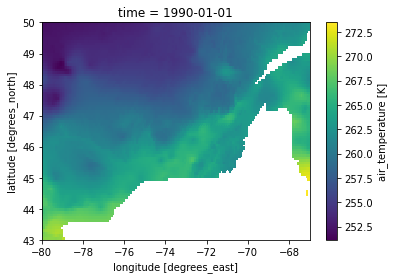

In [4]:
ds = xr.open_dataset(tasmin_url)
ds.tasmin.isel(time=0).plot();

## 1. Simple bounding box subsetting

We call the `subset_bbox` process. Western hemisphere longitudes can be given as negative numbers or positive ones, no matter what range the dataset uses (longitudes are either in `[-180, 180[`  or `[0, 360[`).

The box chosen here is over the city of Montréal and surroundings.

In [5]:
resp = wps.subset_bbox(tasmin_url, lon0=-74.2, lon1=-73.3, lat0=45.25, lat1=45.80, variable=['tasmin'])

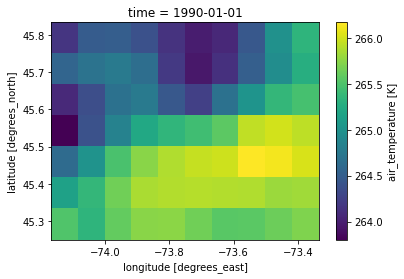

In [6]:
ds_mtl = resp.get(asobj=True).output
ds_mtl.tasmin.isel(time=0).plot();

## 2. Polygon subsetting

The subset processes of finch also support subsetting from a polygon input. Polygons are passed as GeoJSON or zipped-ShapeFiles files. They can be either local or remote.

In this example, we will retrieve a dataset of polygons from a GeoServer instance through another OGC protocol : "WFS". We will then select the polygon we want using GeoPandas, write it down in a local file and send the subsetting request to finch.

The subsetting methods are provided under-the-hood by `clisops` and use a simple method : cells where the center gridpoint lies within the polygon are included. Thus, small or intricate polygons might not return the expected output.

In [7]:
from owslib.wfs import WebFeatureService
import json
import geopandas as gpd
from pathlib import Path
from birdy import WPSClient

wfs_url = 'http://pavics.ouranos.ca/geoserver/wfs'
# Connect to GeoServer WFS service.
wfs = WebFeatureService(wfs_url, version='1.1.0')

#### Downloading and handling polygons locally

This first example shows how to download a collection of polygons from the GeoServer using WFS and `owslib`. The polygon selection is done with `geopandas`, locally, allowing for more polygon processing if needed.

In [8]:
# Get the json as a binary stream
# Here we select Quebec's MRCs polygons
# We select only a few properties to be returned.
data = wfs.getfeature(
    typename='TravisTest:region_admin_poly',
    #bbox=(-93.1, 41.1, -75.0, 49.6),
    outputFormat='json',
    propertyname=['the_geom', 'RES_NM_REG']
)
# Load into a GeoDataFrame by reading the json on-the-fly
all_shapes = gpd.GeoDataFrame.from_features(json.load(data))
all_shapes

,geometry,RES_NM_REG,bbox
0,"MULTIPOLYGON (((-66.68780 55.00000, -66.64290 ...",Côte-Nord,"[-66.6878, 54.9767, -66.6216, 55.0001]"
1,"MULTIPOLYGON (((-66.25980 55.00000, -66.25000 ...",Côte-Nord,"[-66.2598, 54.5973, -63.5512, 55]"
2,"MULTIPOLYGON (((-67.21920 55.00000, -67.00000 ...",Côte-Nord,"[-67.2244, 54.7121, -66.586, 55]"
3,"MULTIPOLYGON (((-72.07340 47.95000, -72.12360 ...",Saguenay - Lac-Saint-Jean,"[-74.4717, 47.95, -69.8711, 52.8325]"
4,"MULTIPOLYGON (((-67.15330 49.18910, -66.99930 ...",Gaspésie - Îles-de-la-Madeleine,"[-67.6666, 46.84, -60.4038, 49.7188]"
5,"MULTIPOLYGON (((-67.15330 49.18910, -66.92890 ...",Bas-Saint-Laurent,"[-70.1982, 47.0666, -65.9485, 49.1891]"
6,"MULTIPOLYGON (((-75.52110 47.84700, -75.72520 ...",Abitibi-Témiscamingue,"[-79.5793, 46.2064, -75.5201, 49.0096]"
7,"MULTIPOLYGON (((-74.47170 48.94560, -74.23090 ...",Mauricie,"[-75.5213, 46.1512, -71.8905, 49.0001]"
8,"MULTIPOLYGON (((-72.07340 47.95000, -72.00000 ...",Capitale-Nationale,"[-72.5407, 46.5698, -69.5484, 48.1861]"
9,"MULTIPOLYGON (((-75.52110 47.84700, -75.52130 ...",Outaouais,"[-77.9316, 45.3708, -74.6981, 47.8476]"


In [9]:
# Select 3 regions around the city of Montréal (drop unused "bbox" dimension)
poly_mtl = all_shapes[all_shapes.RES_NM_REG.isin(['Montérégie', 'Montréal', 'Laval'])].drop(columns=['bbox'])
poly_mtl

,geometry,RES_NM_REG
14,"MULTIPOLYGON (((-72.99210 46.11180, -72.97360 ...",Montérégie
16,"MULTIPOLYGON (((-73.52310 45.69790, -73.52120 ...",Montréal
17,"MULTIPOLYGON (((-73.74490 45.66860, -73.74110 ...",Laval


In [10]:
# Write to file
poly_file = Path('mtl_raw.geojson')
poly_mtl.to_file(poly_file, driver='GeoJSON')

Now that we have a (multipart) polygon, we can call the WPS subset process. When passing a local file, birdy requires the path to be absolute, our use of a `Path` object makes this easy. Before subsetting, the three polygons of our GeoJSON will be merged as one.

In [11]:
resp = wps.subset_polygon(tasmin_url, poly_file.absolute(), variable=['tasmin'])

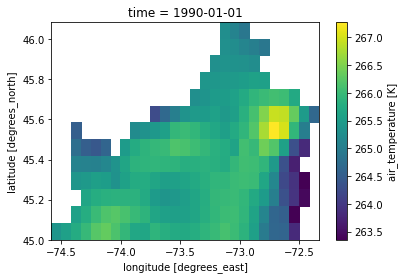

In [12]:
ds_mtl = resp.get(asobj=True).output
ds_mtl.tasmin.isel(time=0).plot();

## 3. Averaging over polygons

Finch also provides an `average_subset` process. The call is similar, but it instead averages the data over each polygon in the GeoJSON. In this case, in opposition to `subset_shape`, the intersection between polygon and grid cells is more exact : holes and partial overlaps are considered. This does come to the cost of a slower execution, which can cause time-outs, the second example shows a way around.


### A) Basic averaging

In [13]:
# Basic example, let's simply reuse the same geojson:
resp = wps.average_polygon(tasmin_url, poly_file.absolute(), variable=['tasmin'])

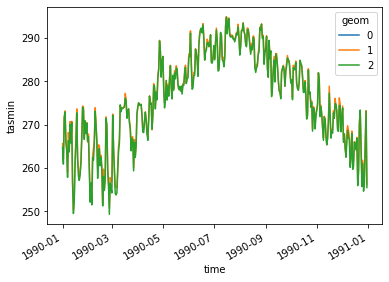

In [14]:
ds_avgmtl = resp.get(asobj=True).output
ds_avgmtl.tasmin.plot(hue='geom');

In [15]:
ds_avgmtl

<xarray.Dataset>
Dimensions:     (geom: 3, time: 365)
Coordinates:
  * time        (time) datetime64[ns] 1990-01-01 1990-01-02 ... 1990-12-31
    lon         (geom) float64 ...
    lat         (geom) float64 ...
  * geom        (geom) int64 0 1 2
    RES_NM_REG  (geom) object ...
Data variables:
    tasmin      (time, geom) float64 ...

### B) High-resolution polygons

The pavics finch server limits the uploads to 3 MB, so our polygon file is limited to that size. In any case, a 3 MB polygon is already quite large and will take a long time to process. Here, we download another polygon (the whole Québec province) and simplify it _before_ sending it to finch.

In [16]:
# Get polygon dataset from GeoServer
data = wfs.getfeature(
    typename='public:canada_admin_boundaries',
    # This bbox represents our input data's coverage.
    # Only polygons touching that zone will be returned in the response.
    bbox=(-74.5, 45.2, -73, 46),
    outputFormat='JSON'
)
# Directly read into a GeoDataFrame, drop the bbox column.
all_shapes = gpd.GeoDataFrame.from_features(json.load(data)).drop(columns=['bbox'])
all_shapes

,geometry,PRUID,PRNAME,PRENAME,PRFNAME,PREABBR,PRFABBR
0,"MULTIPOLYGON (((-74.63810 44.99980, -74.63860 ...",24,Quebec / Qubec,Quebec,Qubec,Que.,Qc
1,"MULTIPOLYGON (((-82.68870 41.68450, -82.68630 ...",35,Ontario,Ontario,Ontario,Ont.,Ont.


In [17]:
# Create a Dataframe with simplified polygons
poly_simple = all_shapes.copy()
poly_simple['geometry'] = all_shapes.simplify(tolerance=0.01)

In [18]:
# Write polygons to geojson files.
poly_file = Path('qc_simp.geojson')
poly_simple.to_file(poly_file, driver='GeoJSON')

# Write the unsimplfied version for comparison only
all_shapes.to_file('qc_raw.geojson', driver='GeoJSON')

In [19]:
# As we can see, the simplified version is way smaller than the raw.
# Finch will not accept inputs larger than 3 Mo (raises "BrokenPipe" error)
# But even with ~2 Mo, the process is to slow and might time out
!du -hs *.geojson

28K	mtl_raw.geojson
16M	qc_raw.geojson
800K	qc_simp.geojson


In [20]:
resp = wps.average_polygon(
    resource=tasmin_url, 
    shape=poly_file.absolute(),
    variable='tasmin'
)

In [21]:
avg = resp.get(asobj=True).output
avg

<xarray.Dataset>
Dimensions:  (geom: 2, time: 365)
Coordinates:
  * time     (time) datetime64[ns] 1990-01-01 1990-01-02 ... 1990-12-31
    lon      (geom) float64 ...
    lat      (geom) float64 ...
  * geom     (geom) int64 0 1
    PRUID    (geom) object ...
    PRNAME   (geom) object ...
    PRENAME  (geom) object ...
    PRFNAME  (geom) object ...
    PREABBR  (geom) object ...
    PRFABBR  (geom) object ...
Data variables:
    tasmin   (time, geom) float64 ...